In [1]:
import os

if "jbook" in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../..")))
import warnings

warnings.filterwarnings("ignore")
FORCE = False

# AppVoCAI Dataset Unboxing
In this section, we unbox the dataset, survey its key characteristics, profile its structure, format, and data types, then register it as an asset, prior to downstream data quality assessment, cleaning, enrichment and analysis activities.

In [2]:
from discover.app.eda import EDA
from discover.container import DiscoverContainer
from discover.infra.config.flow import FlowConfigReader
from explorify.eda.visualize.visualizer import Visualizer
from discover.core.flow import StageDef, PhaseDef
from discover.flow.data_prep.ingest.stage import IngestionStage
from discover.infra.utils.visual.print import Printer

In [3]:
container = DiscoverContainer()
container.init_resources()
container.wire(
    modules=[
        "discover.flow.data_prep.base.stage",
        "discover.app.base",
    ],
)

## Ingest Data
The IngestionStage loads the raw data, and performs encoding verification, data type casting, and removal of newlines from the review text, ensuring data accessibility for downstream processing and analysis.   

The following orchestrates the initialization and execution of the Ingestion pipeline within a broader data preparation workflow. It begins with the retrieval of a specific configuration through the `FlowConfigReader`. This reader is tasked with pulling the configuration that defines the parameters for the pipeline, specifically targeting the `INGEST` stage within the `DataPrep` phase. This configuration encapsulates the structure, settings, and tasks required for ingesting the data.

With the configuration in hand, the code then proceeds to the next step: the construction of the `IngestionStage` pipeline. Using the `build` method of the `IngestionStage` class, it dynamically assembles the pipeline, injecting the necessary configurations and optionally setting a flag to force the execution of the pipeline, even if the destination data already exists. This enables flexibility, allowing the pipeline to rerun when necessary, or to skip execution if the data is up to date.

Finally, the pipeline is executed by invoking the `run()` method, triggering the ingestion workflow, applying the defined tasks and operations. Upon successful execution, the method returns an asset ID, serving as a reference to the processed data. This asset ID can be used for subsequent stages or for tracking the output of the pipeline. 

In [4]:
# Obtain the configuration
reader = FlowConfigReader()
stage_config = reader.get_stage_config(phase=PhaseDef.DATAPREP, stage=StageDef.INGEST)

# Build and run Data Ingestion Stage
stage = IngestionStage.build(
    stage_config=stage_config, return_dataset=True, force=FORCE
)
dataset = stage.run()
df = dataset.content

[11/19/2024 08:03:12 PM] [DEBUG] [IngestionStage.run] [wrapper] : Stage: Data Ingestion Stage
[11/19/2024 08:03:12 PM] [DEBUG] [IngestionStage.run] [wrapper] : Stage Started: Tue, 19 Nov 2024 20:03:12
[11/19/2024 08:03:12 PM] [DEBUG] [IngestionStage.run] [wrapper] : Stage Completed: Tue, 19 Nov 2024 20:03:12
[11/19/2024 08:03:12 PM] [DEBUG] [IngestionStage.run] [wrapper] : Stage Runtime: 0.11 seconds
[11/19/2024 08:03:12 PM] [DEBUG] [IngestionStage.run] [wrapper] : Cached Result: True




# ============================================================================== #
#                              Data Ingestion Stage                              #
# ============================================================================== #



                              Data Ingestion Stage                              
                           Stage Started | Tue, 19 Nov 2024 20:03:12
                         Stage Completed | Tue, 19 Nov 2024 20:03:12
                           Stage Runtime | 0.11 seconds
                           Cached Result | True


# ============================================================================ #



## AppVoCAI Dataset Summary
Let's  load and summarize the data.

In [5]:
reviews = EDA(df=dataset.content)
reviews.summary()



                            AppVoCAI Dataset Summary                            
                       Number of Reviews | 8,670
                     Number of Reviewers | 8,668
              Number of Repeat Reviewers | 2 (0.0%)
         Number of Influential Reviewers | 578 (6.7%)
                          Number of Apps | 2,700
                    Number of Categories | 14
                   Average Review Length | 31.3
                 Average Reviews per App | 3.2
                                Features | 12
                        Memory Size (Mb) | 5.78
                    Date of First Review | 2020-01-01 01:21:10
                     Date of Last Review | 2023-09-03 01:38:20


As evidenced here, we've extracted 8.7 million reviews dated between January of 2020, and September of 2023. These reviews were contributed by over 7 million unique users, with approximately 14% identified as repeat reviewers. Notably, over 7% of the reviewers qualify as influencers, defined by having at least one review with a non-zero vote count. The dataset encompasses nearly 35,000 apps spanning 14 distinct categories. On average, each review contains 32 words, while the average number of reviews per app nears 250. With a memory footprint of 5.8 GB, the dataset is of a moderately large scale, posing both opportunities and challenges for data processing and analysis.

## Structural Analysis
Before examining the content of the dataset, let's inspect its format and structure. 

In [6]:
reviews.info()

,Column,DataType,Complete,Null,Completeness,Unique,Duplicate,Uniqueness,Size (Bytes)
0,id,string[python],8670,0,1.0,8670,0,1.000000,581452
1,app_id,string[python],8670,0,1.0,2700,5970,0.311419,576393
2,app_name,string[python],8670,0,1.0,2700,5970,0.311419,705832
3,category_id,category,8670,0,1.0,14,8656,0.001615,10080
4,author,string[python],8670,0,1.0,8668,2,0.999769,667590
5,rating,Int16,8670,0,1.0,5,8665,0.000577,26010
6,content,string[python],8670,0,1.0,8356,314,0.963783,4212088
7,vote_sum,Int64,8670,0,1.0,18,8652,0.002076,78030
8,vote_count,Int64,8670,0,1.0,22,8648,0.002537,78030
9,date,datetime64[ms],8670,0,1.0,8670,0,1.000000,69360


Several impressions:

1. **ID and Uniqueness**: The `id` column is showing some duplication (104 items) which will require treatment during the data cleaning stage.

2. **App-Specific Details (`app_id`, `app_name`)**: The cardinality of `app_id` exceeds that of `app_name` by 14, which indicates that some apps may have multiple ids, perhaps to uniquely identify different versions of the same app.

3. **Category Distribution**:  `category_id` and `category` are consistent, each with only 14 unique categories, suggesting clear category classifications across apps. 

4. **Authors and Reviews**: Duplication stats for the `author` column indicate that approximately 29% of the authors have submitted multiple reviews; yet, the vast majority of authors in the dataset have minimal engagement. 

5. **Rating Consistency**: The `rating` column has only 5 unique values, presumably in [1,5], to be confirmed below.

6. **Vote Metrics (`vote_count`, `vote_sum`)**: Both `vote_count` and `vote_sum` have low uniqueness, suggesting that vote distributions are limited in range, possibly clustering around common values.

7. **Review Content**: Review content occupies approximately 4.26 Gb of memory, with a duplication rate approaching 12% (992,095 reviews). Duplication in text-based user generated content often indicates common patterns such as emojis and sentiment expressions throughout the dataset.

8. **Date**: Review `date` is appropriately typed as a datetime64 objects, representing an offset from 1970-01-001T00:00:00. Values range from 2008-07-10 10:15:37 to 2023-09-03 02:14:35.

9. **Data Completeness**: All columns are 100% complete, with no missing values, ensuring the dataset’s integrity for analysis.

10. **Data Format:** Most of the variables are appropriately typed. Casting `category_id` to category, and converting *object* types to *string* types will improve IO, storage efficiency and memory utilization.  

11. **Data Volume and Memory Considerations**: The dataset weighs in at about 5.8 Gb of memory, which may require special consideration during data preprocessing, analysis, and modeling stages. For instance, certain aggregations and computationally expensive analytics can be precomputed and re-used during the analysis stages, avoiding expensive calculations and supporting real-time analytics, and decreased iteration cycle times. 



## Category Coverage
The dataset spans 14 categories. Let's examine their distribution in terms of counts and proportions.

[11/19/2024 08:03:13 PM] [DEBUG] [matplotlib.pyplot] [switch_backend] : Loaded backend module://matplotlib_inline.backend_inline version unknown.
[11/19/2024 08:03:13 PM] [DEBUG] [matplotlib.pyplot] [switch_backend] : Loaded backend module://matplotlib_inline.backend_inline version unknown.
[11/19/2024 08:03:13 PM] [DEBUG] [matplotlib.font_manager] [_findfont_cached] : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[11/19/2024 08:03:13 PM] [DEBUG] [matplotlib.font_manager] [_findfont_cached] : findfont: score(FontEntry(fname='/home/john/miniconda3/envs/appvocai/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[11/19/2024 08:03:13 PM] [DEBUG] [matplotlib.font_manager] [_findfont_cached] : findfont: score(FontEntry(fname='/home/john/miniconda3/envs/appvocai/lib/python3.10/site-packages/matplotlib/mpl-data/fonts

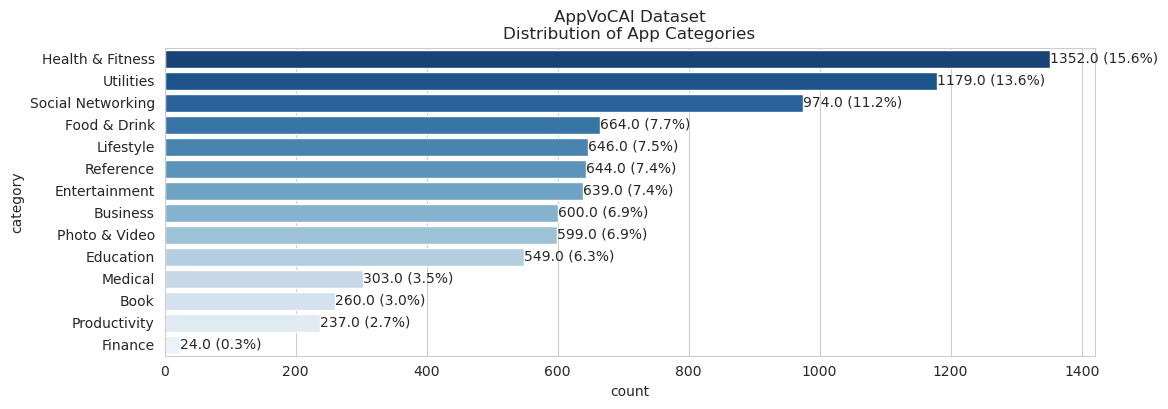

In [7]:
viz = Visualizer()
ax = viz.countplot(
    data=df,
    y="category",
    title="AppVoCAI Dataset\nDistribution of App Categories",
    order_by_count=True,
    plot_counts=True,
)

The distribution of reviews by app category in the AppVoCAI dataset provides insight into how review data is represented within this particular dataset, rather than reflecting any actual usage or popularity patterns in the app store at large.

1. **Higher Representation in Health & Fitness, Utilities, and Social Networking**: Categories such as Health & Fitness (15.6%), Utilities (13.7%), and Social Networking (11.4%) have the largest share of reviews in this dataset. This may reflect the way data was randomly sampled, rather than indicating a larger user base or greater engagement in these categories across the app store.

2. **Diverse Representation Across Lifestyle, Entertainment, and Food & Drink**: Categories like Lifestyle, Entertainment, and Food & Drink are also well represented in this dataset, accounting for a moderate portion of the reviews. Again, this distribution may simply result from the dataset's random sampling approach, rather than indicating broader trends.

3. **Lower Review Counts in Finance and Medical**: Some categories, such as Finance (0.3%) and Medical (3.5%), show fewer reviews in this dataset. This does not imply these categories are less popular or less reviewed in the app store but simply reflects the structure of this specific dataset.

4. **Focus on Dataset-Specific Insights**: While this distribution does not represent actual app store trends, it does provide an opportunity to examine patterns and themes within each category as represented in this dataset. For example, the high representation of certain categories might allow for a richer analysis of user sentiment or feature requests in those domains.

Again, this distribution should be viewed as unique to the AppVoCAI dataset, shaped by the random and stochastic nature of the acquisition process rather than as a representation of category popularity or review volume in the broader app store context.

## AppVoCAI Dataset Sample Observations 
To gain an initial, qualitative sense of the AppVoCAI dataset, let's take an early peek at a few randomly selected observations from the dataset. 

In [8]:
samples = df.sample(n=5, random_state=50)
samples

,id,app_id,app_name,category_id,author,rating,content,vote_sum,vote_count,date,review_length,category
6170,9401928455,282935706,Bible,6006,dfeea0e593500f0892ce,5,Having this app on my phone has been such a bl...,0,0,2022-12-16 12:12:00,28,Reference
675,7481240761,371294472,Shopify - Your Ecommerce Store,6000,0ac08902f4ac23fd8029,1,"Almost one year , and the app keep log me out ...",0,0,2021-06-19 07:16:00,37,Business
5128,5945998457,544007664,"YouTube: Watch, Listen, Stream",6008,0ea211cbe0bf26a01843,1,The suggested is terrible and the new comments...,0,0,2020-05-14 23:18:02,21,Photo & Video
4909,9601446640,471942748,Glooko - Track Diabetes Data,6020,52c2b9cf6f1376c3e1a6,1,The latest update of Glooko app will not conne...,0,0,2023-02-10 03:25:59,112,Medical
5483,7899369255,962194608,Google Photos,6008,d0fec28e0593b9180aad,5,This app has been awesome in guiding me throug...,0,0,2021-10-10 14:53:36,21,Photo & Video


This sample illustrates a range of sentiments (ratings) and experiences, with several notable characteristics:

1. **Lack of Votes**: None of the reviews have received votes, indicating low engagement with the feedback itself. This lack of interaction might suggest that users don’t often upvote or downvote reviews, potentially limiting the visibility of insightful feedback for future users.

2. **Moderate Variation in Review Length**: The reviews vary from brief (11 characters) to more moderately detailed (up to 21 characters), reflecting a mix of concise and slightly elaborative feedback. This variation impacts the depth of analysis, as shorter reviews often lack detailed context, whereas slightly longer ones provide a more comprehensive view of user sentiment.

3. **Presence of Emoticons in Text**: The use of emoticons, as seen in the Apple TV review, adds a layer of emotional context that underscores a positive sentiment. Emoticons may help express feelings that aren’t fully captured in text alone, adding another dimension to sentiment analysis.

4. **Anonymized Author IDs**: Each review features an anonymized author ID, which is useful for tracking user feedback trends while preserving privacy. Analyzing reviews by recurring authors could reveal patterns in user loyalty, repeated issues, or consistent satisfaction.

5. **Wide Range of Dates**: The reviews span dates from 2020 to 2023, indicating a mix of older and recent feedback. This time range allows for tracking changes in user satisfaction over time, potentially correlating with updates, new features, or policy changes.

Let's briefly analyze each review in the sample to gain a qualitative sense of their user experiences, focusing on elements such as performance, usability, and service satisfaction. 

### DoorDash - Food Delivery	

In [9]:
printer = Printer()
printer.print_dataframe_as_dict(
    df=samples, list_index=0, title=samples["app_name"].values[0], text_col="content"
)



                                     Bible                                      
                                      id | 9401928455
                                  app_id | 282935706
                                app_name | Bible
                             category_id | 6006
                                  author | dfeea0e593500f0892ce
                                  rating | 5
                                vote_sum | 0
                              vote_count | 0
                                    date | 2022-12-16 12:12:00
                           review_length | 28
                                category | Reference
Having this app on my phone has been such a blessing; especially the daily
verses and prayers I have created which remind me to pause daily to pray.


This review provides a sharp example of negative user feedback that emphasizes critical customer service and policy issues. Here's a breakdown of the content and its potential implications for further analysis:

1. **Service Failure Highlight**: The user's complaint centers around DoorDash's handling of restaurant errors, specifically when a significant part of an order is missing. This indicates a gap in the customer service experience that may frustrate many users. Complaints about missing order components are especially severe in the food delivery industry, where the entire purpose of the service hinges on accurate and timely fulfillment.

2. **Policy Critique**: The user mentions that DoorDash’s response to this issue is rooted in "policy," which suggests an inflexible or unhelpful approach. The word "policy" here implies that the company’s rules may not be user-friendly or adaptable to real-world problems, which could negatively affect overall satisfaction. This sentiment may indicate an opportunity for DoorDash to reevaluate its customer support policies, especially those dealing with restaurant-related errors.

3. **Warning to Potential Users**: The closing word, "Beware," serves as a cautionary note to others. It’s an indicator of the strength of the user's dissatisfaction and serves as a reminder of how negative experiences can translate into reputational damage for the brand.

4. **Category Context**: This review falls under the "Food & Drink" category, where prompt, efficient, and customer-oriented service is crucial. Policy-driven responses that fail to resolve issues could significantly undermine user trust and brand loyalty.

5. **Rating**: The user gave a 1-star rating, the lowest possible, which reflects severe dissatisfaction. Such ratings contribute heavily to a negative sentiment toward the app and could indicate recurring themes when analyzed in aggregate.

**Implications for Analysis**: This review suggests a need for deeper investigation into themes related to customer support effectiveness and policy inflexibility. In an Aspect-Based Sentiment Analysis (ABSA) framework, aspects like "customer service" (negative) and "order accuracy" (negative) would be flagged. The review also underscores the importance of flexible and customer-oriented solutions in maintaining trust and satisfaction, critical factors for user retention and brand perception in the food delivery sector.

### Gboard – the Google Keyboard                          


In [10]:
printer.print_dataframe_as_dict(
    df=samples, list_index=1, title=samples["app_name"].values[1], text_col="content"
)



                         Shopify - Your Ecommerce Store                         
                                      id | 7481240761
                                  app_id | 371294472
                                app_name | Shopify - Your Ecommerce Store
                             category_id | 6000
                                  author | 0ac08902f4ac23fd8029
                                  rating | 1
                                vote_sum | 0
                              vote_count | 0
                                    date | 2021-06-19 07:16:00
                           review_length | 37
                                category | Business
Almost one year , and the app keep log me out almost everyday, i change my phone
and still its log me out and I have to login again everyday, hope you can fix
this issue ASAP


This review sheds light on a negative user experience, specifically focused on performance and reliability issues. Here's a breakdown of the content and implications for further analysis:

1. **Initial Positive Sentiment**: The user mentions that they “loved it earlier,” which suggests that Gboard was initially a satisfying and effective tool. This indicates that a decline in performance, rather than a longstanding flaw, is the root of their dissatisfaction. For product teams, this information can guide investigations into what recent changes or updates may have caused the decline.

2. **Performance and Usability Issues**: The core complaint revolves around the app “acting weird,” flashing on the screen, and then reverting to the regular keyboard. This points to a severe performance bug that interrupts the user experience. The intermittent nature of the issue, described as the app flashing and then defaulting, implies that there might be problems with app stability, resource management, or compatibility with other device components.

3. **Category Context**: As a “Utilities” app, Gboard is expected to be reliable, stable, and seamlessly integrated into everyday use. Users rely heavily on their keyboards for daily communication, so any instability can be highly disruptive. This makes performance and reliability critical aspects to prioritize.

4. **Rating**: The 1-star rating reflects extreme dissatisfaction and suggests that the issue is significant enough to warrant such a negative review. Persistent performance problems like these could contribute to a decline in user retention and a negative brand image.

**Implications for Analysis**: This review highlights a need for the development team to prioritize fixing stability and performance-related bugs. In an Aspect-Based Sentiment Analysis (ABSA) framework, aspects like “performance” (negative) and “stability” (negative) would be flagged. Furthermore, this feedback emphasizes the importance of regular performance testing and monitoring for updates that may introduce new issues. Addressing such critical bugs could help improve user satisfaction and mitigate further reputational damage.

### Apple TV    

In [11]:
printer.print_dataframe_as_dict(
    df=samples, list_index=2, title=samples["app_name"].values[2], text_col="content"
)



                         YouTube: Watch, Listen, Stream                         
                                      id | 5945998457
                                  app_id | 544007664
                                app_name | YouTube: Watch, Listen, Stream
                             category_id | 6008
                                  author | 0ea211cbe0bf26a01843
                                  rating | 1
                                vote_sum | 0
                              vote_count | 0
                                    date | 2020-05-14 23:18:02
                           review_length | 21
                                category | Photo & Video
The suggested is terrible and the new comments are terrible. They are trying to
milk people for more advertisement revenue. Ridiculous.


This review provides a brief yet positive user experience summary. Here's a breakdown of its content and implications for further analysis:

1. **Concise Positive Sentiment**: The review is extremely short, which makes it challenging to identify specific elements of the app that the user appreciates. However, the 5-star rating strongly indicates high satisfaction. Positive feedback, even when minimal, is important for reinforcing which aspects of the app might be performing well, though additional detail would be needed to pinpoint these aspects accurately.

2. **Category Context**: The app belongs to the "Entertainment" category, where content quality, ease of navigation, and seamless streaming are likely important aspects. Users who rate entertainment apps highly typically appreciate reliable performance, high-quality content, or an intuitive user interface. While this review does not specify, these elements may be inferred as possible contributors to the positive rating.

3. **Implications for Sentiment Analysis**: Due to the brevity of this review, there are no identifiable themes or aspects to analyze in detail. However, in a broader sentiment analysis, short but high-rated reviews contribute to the overall positive sentiment of the app. This review could be grouped with others to identify general satisfaction trends or infer common themes through further aggregated analysis.

4. **Impact of High Rating**: A 5-star review boosts the app's average rating and indicates user approval. While it’s not informative on its own, it serves as a valuable piece of data for overall sentiment measurement.

**Implications for Further Analysis**: This review highlights the challenge of extracting meaningful insights from brief feedback. It emphasizes the importance of encouraging users to leave more detailed reviews, especially in the "Entertainment" category, where specifics about user experience (like content offerings, interface design, or streaming quality) can be crucial for app improvement.

### Messenger                                                   


In [12]:
printer.print_dataframe_as_dict(
    df=samples, list_index=3, title=samples["app_name"].values[3], text_col="content"
)



                          Glooko - Track Diabetes Data                          
                                      id | 9601446640
                                  app_id | 471942748
                                app_name | Glooko - Track Diabetes Data
                             category_id | 6020
                                  author | 52c2b9cf6f1376c3e1a6
                                  rating | 1
                                vote_sum | 0
                              vote_count | 0
                                    date | 2023-02-10 03:25:59
                           review_length | 112
                                category | Medical
The latest update of Glooko app will not connect or HOLD a connection with my
Dexcom G6 sensor. Keep deleting device form website profile and from the app and
try reconnecting. I get to the point where I get to select the Dexcom G6 in the
Glooko app and log into my Dexcom acct. Then it says I’m connected and then
turns around an

This review highlights a significant and specific issue related to app accessibility. Here's a breakdown of the content and implications:

1. **Login Issue**: The core complaint is centered around the inability to log in, with the app displaying an "unknown error" message. This suggests a major functionality problem that directly affects the app's usability. Login failures are critical issues in social networking apps, where continuous access is crucial for user engagement and retention.

2. **Impact on User Experience**: The review’s brevity and 1-star rating emphasize the frustration associated with being locked out of an account. This kind of problem can have a serious impact on user trust, as people rely on social networking apps to stay connected and manage communication. Unresolved login issues could lead to a loss of active users.

3. **Category Context**: In the "Social Networking" category, accessibility and reliability are paramount. Users expect seamless login experiences, and any disruptions can severely impact the perceived quality of the service. This feedback points to the need for a robust authentication system and effective error messaging to guide users when issues arise.

4. **Rating**: The 1-star rating signals extreme dissatisfaction, likely reflecting how essential access is for this app’s functionality. Reviews like this can contribute significantly to a negative overall sentiment if similar complaints are frequent.

**Implications for Analysis**: This review suggests that the development team should investigate potential causes for login errors and ensure that error messages are informative. In an Aspect-Based Sentiment Analysis (ABSA) framework, aspects like "login functionality" (negative) and "error handling" (negative) would be highlighted. Furthermore, focusing on user support for account recovery or troubleshooting could help mitigate frustration and improve user retention.

### MyFitnessPal: Calorie Counter App Review

In [13]:
printer.print_dataframe_as_dict(
    df=samples, list_index=4, title=samples["app_name"].values[4], text_col="content"
)



                                 Google Photos                                  
                                      id | 7899369255
                                  app_id | 962194608
                                app_name | Google Photos
                             category_id | 6008
                                  author | d0fec28e0593b9180aad
                                  rating | 5
                                vote_sum | 0
                              vote_count | 0
                                    date | 2021-10-10 14:53:36
                           review_length | 21
                                category | Photo & Video
This app has been awesome in guiding me through the process of organizing my
photos and getting rid of unneeded documents.


This review provides balanced feedback, including both praise and suggestions for improvement. Here's a breakdown of the content and implications:

1. **Positive Feature Mention**: The user appreciates the barcode scanner feature, indicating that it is well-implemented and useful. Positive mentions like this are valuable for highlighting features that resonate with users and should be maintained or further enhanced. In the Health & Fitness category, functionality that simplifies meal tracking, such as a barcode scanner, is crucial for user engagement and satisfaction.

2. **Constructive Criticism**: The user suggests that the restaurant offerings be listed in alphabetical order, which would improve usability. This feedback points to a specific area where the app’s navigation or content organization could be refined. Enhancing the user experience by reorganizing content in a more intuitive manner could make meal selection and tracking more efficient.

3. **Category Context**: As a Health & Fitness app, WW / WeightWatchers is used for managing diet and nutrition. Efficient organization and ease of use are critical factors for user satisfaction. The suggestion to improve the organization of restaurant listings aligns with the expectation for streamlined, user-friendly features in this category.

4. **Rating**: The 4-star rating reflects a generally positive experience with room for improvement. The user is satisfied overall but sees potential for enhancement. This rating provides a constructive viewpoint, indicating that the app is strong but could be improved with relatively minor adjustments.

**Implications for Analysis**: This review suggests that the barcode scanner feature is a highlight for users and should be a continued focus for development. In an Aspect-Based Sentiment Analysis (ABSA) framework, aspects like “barcode scanner” (positive) and “organization of restaurant listings” (neutral/negative) would be flagged. The feedback also underscores the importance of organizing content in a way that facilitates easy access, a consideration that could improve the overall user experience and potentially increase user satisfaction.

## Summary 
The AppVoCAI dataset contains 8.7 million reviews, submitted by approximately 7.2 million users across 34,871 apps. It is complete with no missing values; although, some `id` duplication was extant which we will address during the data cleaning effort. A sample inspection revealed a range of sentiments, review qualities, syntactic complexity and lexical diversity. Moderately large, this nearly 6 Gb dataset raises opportunities and challenges for computationally efficient data processing and analysis. 

## Next Steps
It's a settled debate: data quality is *still* a vital determining factor in AI model performance, accurate analytics, and data-driven decision making {cite}`jainOverviewImportanceData2020a`, with data quality dimensions such as *completeness*, *validity*, *consistency*, and *diversity* accounting for substantial *variance* in model performance {cite}`budachEffectsDataQuality2022`. For Large Language Models (LLMs), text quality upper bounds LLM's ability to accurately capture, and understand the nuances, complexities, and subtleties of human language. High quality text data ensures nuances are preserved, allowing models to more effectively perform tasks such as sentiment analysis, question/answering, language prediction. A robust data quality analysis addressing dimensions of completeness, uniqueness, target category balance, validity, and interpretability will evince quality issues early in the workflow; thereby, minimizing the risk of data bias and model prediction error and degredation. 

To position ourselves for thorough data quality analysis, we will take the following steps in the coming sections. First, we will perform sentiment analysis to get a high-level sense of the distribution and balance within the dataset. Second, a text quality detection (DQA) effort will illuminate the degree of noise in the review text. Finally, a text quality analysis (TQA) will score each review based upon syntactic complexity, lexical diversity and coherence - critical for LLM fine-tuning. This data enrichment investment will manifest considerable returns during data quality analysis, and subsequent exploratory and modeling stages.

Next up? Sentiment analysis. Fire up the GPUs! 